In [1]:
!pip3 install pyro-ppl

     |████████████████████████████████| 718 kB 4.2 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [2]:
import pyro
import pyro.distributions as dist

import random

import numpy as np

import torch

# 1. Generate Sample Dataset

In [3]:
class GMMSampler:

    def __init__(self, k, d, mu, sigma):
        self.k = k
        self.d = d

        assert mu.size() == (k, d), 'Input mu must be a tensor of size (%i, %i)' % (k, d)
        self.mu = mu

        assert sigma.size() == (k, d), 'Input sigma must be a tensor of size (%i, %i)' % (k, d)
        self.sigma = sigma

        self.init_gaussians()

    def init_gaussians(self):
        self.gaussians = [[dist.Normal(self.mu[k, d], self.sigma[k, d]) for d in range(self.d)] for k in range(self.k)]

    def sample(self, n):
        choices = np.random.choice(self.k, n, replace=True)
        samples = torch.zeros(n, self.d)

        for i, c in enumerate(choices):
            for d in range(self.d):
                component = self.gaussians[c][d] 
                samples[i, d] = component.sample()

        return samples

In [4]:
K = 2 

D = 2 

MU = torch.tensor([[-.5, -.5], [.5, .5]], dtype=torch.float)

SIGMA = torch.tensor([[.1, .1], [.1, .1]], dtype=torch.float)

In [5]:
bimodal_sampler = GMMSampler(K, D, MU, SIGMA)

In [6]:
N = 10000

assert N > K, 'Dataset size N must be greater'

data = bimodal_sampler.sample(N)

data

tensor([[-0.6382, -0.3193],
        [-0.6096, -0.4479],
        [-0.5454, -0.5256],
        ...,
        [-0.4630, -0.5839],
        [ 0.6585,  0.5956],
        [ 0.3498,  0.4556]])

In [7]:
import matplotlib.pyplot as plt

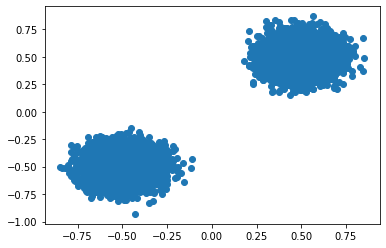

In [8]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [9]:
def split_train_test(data, ratio=0.8):

    N = data.shape[0]
    indices = torch.randperm(N)

    N_train = int(N * ratio)

    train_indices = indices[:N_train]
    test_indices = indices[N_train:]

    data_train = data[train_indices]
    data_test = data[test_indices]

    return data_train, data_test

In [10]:
data_train, data_test = split_train_test(data)

# 2. Define the Pyro Model

In [11]:
from pyro.infer import config_enumerate

from torch.distributions import constraints

In [12]:
K = 2 # number of components

def model(data):

    N = data.shape[0] # number of samples
    D = 1 if len(data.shape) == 1 else data.shape[1] # data dimensionality

    # Global variables as initialized in the paper with Stan 

    # Component weights
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(K) / K))

    # Locs and scales of the components
    with pyro.plate('dimensions', D):
        with pyro.plate('components', K):
            mu = pyro.sample('mu', dist.Normal(torch.tensor([0.]), torch.tensor([1.])))
            sigma = pyro.sample('sigma', dist.LogNormal(torch.tensor([0.]), torch.tensor([1])))

    with pyro.plate('data', N):
        assignment = pyro.sample('assignment', dist.Categorical(theta), infer={'enumerate': 'parallel'})
        pyro.sample('obs', dist.Normal(mu[assignment], sigma[assignment]).to_event(1), obs=data)

# 3. Run ADVI

In [13]:
import torch.nn as nn

import pandas as pd

from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal

import time

from tqdm.notebook import tqdm, trange

In [14]:
theta_init = torch.ones(K) / K
theta_init

tensor([0.5000, 0.5000])

In [15]:
from pyro.infer.autoguide.initialization import init_to_sample, init_to_uniform, init_to_value

init_values = {
    'mu': torch.mean(data_train, dim=0).expand(K, D), 
    'sigma': torch.std(data_train, dim=0).expand(K, D), 
    'theta': torch.ones(K) / K
    }

def run_advi(model, num_iter, num_particles, verbose=False):
    torch.manual_seed(0)

    guide = AutoDiagonalNormal(poutine.block(model, expose=['theta', 'mu', 'sigma']), init_loc_fn=init_to_value(values=init_values, fallback=init_to_sample))
    #guide = AutoDiagonalNormal(poutine.block(model, expose=['theta', 'mu', 'sigma']))
    adaprop = pyro.optim.AdagradRMSProp(dict())

    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(num_particles=num_particles)) # TraceEnum_ELBO is crucial

    pyro.clear_param_store()

    output_advi = pd.DataFrame(columns = ['t', 'test_accuracy', 'model'])

    train_time = 0

    mse_loss = nn.MSELoss()

    for j in trange(num_iter):
        t0 = time.time()
        loss = svi.step(data_train)
        train_time += time.time() - t0
    
        if j % 100 == 0:
            learned_theta = guide.median()['theta']
            learned_mu = guide.median()['mu']
            learned_sigma = guide.median()['sigma']
            
            # Compute Likelihood as in the paper
            test_log_prob = 0
            for n in range(data_test.shape[0]):
                ps = torch.zeros(K, 1)
                for k in range(K):
                    learned_normal = dist.Normal(learned_mu[k], learned_sigma[k])
                    ps[k] = torch.log(learned_theta[k]) + learned_normal.log_prob(data_test[n]).sum()
                test_log_prob += torch.logsumexp(ps.flatten(), dim=-1)

            output_iter = {'t': train_time,
                           'test_accuracy': test_log_prob.detach().numpy(),
                           'model': 'advi{}'.format(num_particles)}
            output_advi = output_advi.append(output_iter, ignore_index=True)
            
            if verbose: 
                print('[iteration %04d] test_accuracy: %.4f' % (j + 1, test_log_prob))  

    return output_advi

In [16]:
# Train the ADVI models
print('Running ADVI with M=1')
output_advi_M1 = run_advi(model, 1000, 1, True)

print('Running ADVI with M=10')
output_advi_M10 = run_advi(model, 1000, 10, True)

Running ADVI with M=1


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2986.2937
[iteration 0101] test_accuracy: -2443.0469
[iteration 0201] test_accuracy: 525.8353
[iteration 0301] test_accuracy: 1870.8623
[iteration 0401] test_accuracy: 2150.1953
[iteration 0501] test_accuracy: 2128.1633
[iteration 0601] test_accuracy: 2157.9944
[iteration 0701] test_accuracy: 2170.3123
[iteration 0801] test_accuracy: 2166.7605
[iteration 0901] test_accuracy: 2162.0735
Running ADVI with M=10


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2987.0391
[iteration 0101] test_accuracy: -1391.4561
[iteration 0201] test_accuracy: 1082.4885
[iteration 0301] test_accuracy: 2051.3604
[iteration 0401] test_accuracy: 2170.1538
[iteration 0501] test_accuracy: 2176.1909
[iteration 0601] test_accuracy: 2175.4050
[iteration 0701] test_accuracy: 2173.2568
[iteration 0801] test_accuracy: 2175.7136
[iteration 0901] test_accuracy: 2176.7344


In [17]:
output_advi_M1

,t,test_accuracy,model
0,0.246915,-2986.2937,advi1
1,2.410951,-2443.0469,advi1
2,4.852979,525.8353,advi1
3,8.972099,1870.8623,advi1
4,13.785240,2150.1953,advi1
5,18.533870,2128.1633,advi1
6,23.725140,2157.9944,advi1
7,25.983801,2170.3123,advi1
8,28.242710,2166.7605,advi1
9,30.475390,2162.0735,advi1


In [18]:
output_advi_M10

,t,test_accuracy,model
0,0.214269,-2987.039,advi10
1,18.724606,-1391.456,advi10
2,37.295316,1082.4885,advi10
3,55.537398,2051.3604,advi10
4,76.156053,2170.1538,advi10
5,99.338132,2176.191,advi10
6,120.894652,2175.405,advi10
7,142.481562,2173.2568,advi10
8,163.967285,2175.7136,advi10
9,185.485435,2176.7344,advi10


# 4. Run NUTS


In [19]:
from pyro.infer import MCMC, NUTS, HMC

In [20]:
def run_mcmc(model, num_samples, num_warmups, kernel_method):
    torch.manual_seed(0)
    
    pyro.clear_param_store()

    test_log_prob_arr = []
    train_time = []

    def hook_fn(kernel, sample, stage, i):
        # Use the most recently sampled param to estimate performance
        if i < 100 or (i % 10 == 0): # Evaluate all first 100 samples and then every 50
            learned_theta = sample['theta'] # RETURNS A ONE-DIMENSIONAL SAMPLE I COULD NOT UNDERSTAND 
            learned_mu = sample['mu']
            learned_sigma = torch.exp(sample['sigma'])

            #print('11111', learned_mu)
            #print('22222', learned_sigma)

            # Compute Likelihood as in the paper
            test_log_prob = 0
            for n in range(data_test.shape[0]):
                ps = torch.zeros(K, 1)
                for k in range(K):
                    learned_normal = dist.Normal(learned_mu[k], learned_sigma[k])
                    if k == K - 1:
                        ps[k] = torch.log(1 - torch.sum(learned_theta)) + learned_normal.log_prob(data_test[n]).sum()
                    else:  
                        ps[k] = torch.log(learned_theta[k]) + learned_normal.log_prob(data_test[n]).sum()
                test_log_prob += torch.logsumexp(ps.flatten(), dim=-1)

            train_time.append(time.time())    
            test_log_prob_arr.append(test_log_prob)

    if kernel_method == 'NUTS':
        kernel = NUTS(model,max_tree_depth=4)
    elif kernel_method == 'HMC':
        kernel = HMC(model,
                     step_size=0.1, 
                     num_steps=10, 
                     target_accept_prob=0.8,
                     adapt_step_size = False)
    else:
        raise Exception('Unknown Kernel Method.')

    nuts = MCMC(kernel,
                num_samples=num_samples,
                warmup_steps=num_warmups,
                disable_progbar=False,
                num_chains=1,
                hook_fn=hook_fn) 

    nuts.run(data_train)

    output_mcmc = pd.DataFrame({'t': np.array(train_time) - train_time[0], 
                                'test_accuracy': np.array(test_log_prob_arr),
                                'model': kernel_method})
    
    return output_mcmc

In [21]:
# Train the MCMC models 
print('Running MCMC with NUTS kernel')
output_nuts = run_mcmc(model, 250, 250, 'NUTS')

print('Running MCMC with HMC kernel')
output_hmc = run_mcmc(model, 2000, 2000, 'HMC')

Running MCMC with NUTS kernel


Sample: 100%|██████████| 500/500 [04:30,  1.85it/s, step size=2.05e-01, acc. prob=0.878]


Running MCMC with HMC kernel


Sample: 100%|██████████| 4000/4000 [15:09,  4.40it/s, step size=1.00e-01, acc. prob=0.000]


In [22]:
output_nuts

,t,test_accuracy,model
0,0.000000,-20831.033203,NUTS
1,0.743388,-20831.033203,NUTS
2,1.504797,-3824.105469,NUTS
3,2.202096,-3058.381592,NUTS
4,2.871718,-3058.381592,NUTS
...,...,...,...
225,250.640276,NaN,NUTS
226,257.253410,224.988495,NUTS
227,261.048313,249.446152,NUTS
228,264.185718,278.650055,NUTS


In [23]:
output_hmc

,t,test_accuracy,model
0,0.000000,-72192.53125,HMC
1,0.814059,-72192.53125,HMC
2,1.623451,-72192.53125,HMC
3,2.437006,-72192.53125,HMC
4,3.260464,-72192.53125,HMC
...,...,...,...
575,899.887099,NaN,HMC
576,901.878619,NaN,HMC
577,903.917255,NaN,HMC
578,905.897725,NaN,HMC


In [24]:
import seaborn as sns

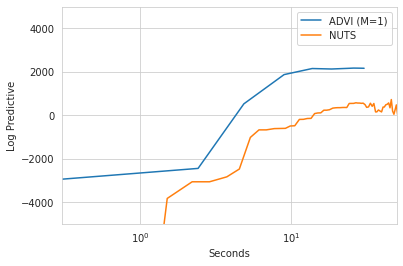

In [38]:
# Generate plot
output = output_advi_M1 #.append(output_advi_M10, ignore_index=True)
output = output.append(output_nuts, ignore_index=True)
#output = output.append(output_hmc, ignore_index=True)
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style('whitegrid')
results = sns.lineplot(data=output, x='t', y='test_accuracy', hue='model')
results.set(xscale='log', 
            xlim=(0.3, 50), 
            ylim=(-5000, 5000),
            xlabel='Seconds',
            ylabel='Log Predictive')
plt.legend(labels=['ADVI (M=1)', 'NUTS']) #, 'HMC'])

In [39]:
# Train the ADVI models
print('Running ADVI with M=50')
output_advi_M50 = run_advi(model, 1000, 50, True)

print('Running ADVI with M=500')
output_advi_M500 = run_advi(model, 1000, 500, True)

Running ADVI with M=50


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2986.5347
[iteration 0101] test_accuracy: -643.4076
[iteration 0201] test_accuracy: 1321.8990
[iteration 0301] test_accuracy: 2089.2158
[iteration 0401] test_accuracy: 2172.2893
[iteration 0501] test_accuracy: 2174.9285
[iteration 0601] test_accuracy: 2176.1365
[iteration 0701] test_accuracy: 2175.9641
[iteration 0801] test_accuracy: 2175.2908
[iteration 0901] test_accuracy: 2175.9568
Running ADVI with M=500


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2987.1636
[iteration 0101] test_accuracy: -562.0399
[iteration 0201] test_accuracy: 1378.8580


KeyboardInterrupt: ignored